In [326]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr
import networkx as nx
from tqdm import tqdm
from pywaffle import Waffle
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the Data

We utilize two primary datasets in our work:

1. **`book_adaptation` Dataset:** This dataset contains information about movies and, when applicable, the books from which they were adapted.

2. **`book` Dataset:** This dataset includes details about books that may not necessarily have movie adaptations.

For an in-depth understanding of how these datasets were created, refer to the Jupyter Notebook `create_dataset.ipynb`.

In [32]:
adaptation_df = pd.read_csv('book_adaptation.csv')
book_df = pd.read_csv('book.csv')

The primary success criterion for our analysis is the revenue generated by each movie. However, we face a challenge since this information is not available for all movies in the dataset. 

To address this, our first step will be to plot the missing revenue entries by year. This will enable us to assess if the availability of revenue data has varied over time, thereby influencing our analysis and interpretations.

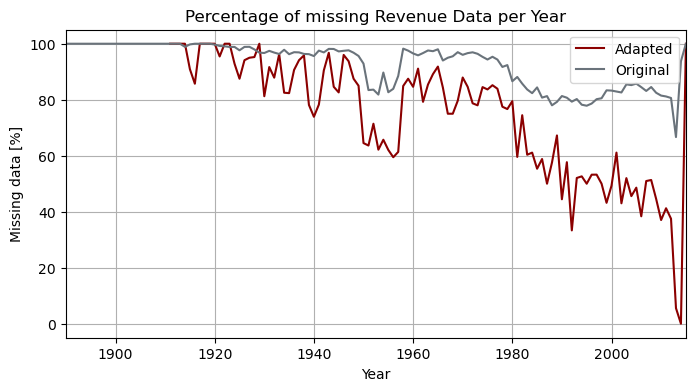

In [33]:
missing_revenue_adaptation_df = (adaptation_df
                                 .query('movie_is_adaptation')
                                 .groupby('movie_release')
                                 ['movie_revenue']
                                 .apply(lambda x: (x.isna().sum()/len(x) * 100))
                                )
missing_revenue_original_df = (adaptation_df
                              .query('~movie_is_adaptation')
                              .groupby('movie_release')
                              ['movie_revenue']
                              .apply(lambda x: (x.isna().sum()/len(x) * 100))
                              )      
plt.figure(figsize=(8, 4))
plt.plot(missing_revenue_adaptation_df.index, missing_revenue_adaptation_df.values, label='Adapted', color='#8B0000')
plt.plot(missing_revenue_original_df.index, missing_revenue_original_df.values, label='Original', color='#6a737b')
plt.xlabel('Year')
plt.ylabel('Missing data [%]')
plt.title('Percentage of missing Revenue Data per Year')
plt.xlim([1890, 2015])
plt.legend()
plt.grid()


**Observations**
- Pre-1920 Data Gap: There is a significant lack of revenue data for movies released before 1920.
- Optimal Timeframe for Analysis (1950-2010): This period shows the lowest proportion of missing revenue data, making it ideal for analysis. Specifically, the missing data is around 50% for movies based on books and approximately 80% for other movies.
- Lower Missing Data for Book-Based Movies: Movies adapted from books exhibit a lower proportion of missing revenue data.

**Possible Explanations**
- Bias Towards Well-Documented, Larger Movies: On Wikidata, larger and more popular movies tend to have more comprehensive entries. By this logic movies for which the data on the book it was based on is available could be more well known in general. The same might be true for revenue data which explains the difference that can be seen in the plot. 

In [34]:
# Only consider movies released between 1950 and 2010
adaptation_df = adaptation_df.query('movie_release >= 1950 and movie_release <= 2010')

At first, determine the proportion of movies in the CMU dataset that are based on books, as identified through Wikidata. The analysis will be visually represented using a waffle plot. 

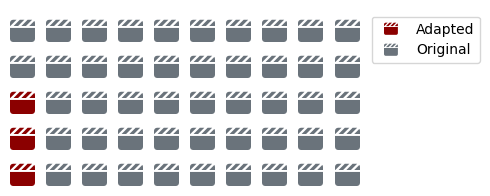

In [35]:
fraction_adapted = round(adaptation_df.movie_is_adaptation.mean() * 100) / 2
fraction_original = (50 - fraction_adapted)
data = {'Adapted': fraction_adapted, 'Original': fraction_original}
fig = plt.figure(
    figsize=(5, 5),
    FigureClass=Waffle,
    rows=5,
    values=data,
    colors=['#8B0000', '#6a737b'],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons=['clapperboard', 'clapperboard'],
    font_size=18,
    icon_legend=True
)
fig.savefig('assets/adaptation_fraction.png', dpi=600, bbox_inches='tight')

### Are Movie Adaptations more successful? 
We aim to determine whether movie adaptations are more successful at the box office in terms of revenue compared to non-adapted movies.

**Possible Coounding Variables**
- **Genre**: Certain genres, like fantasy, might be more prevalent in book adaptations. If these genres inherently perform better at the box office, the success cannot be solely attributed to the movie being an adaptation.
- **Temporal Trends**: The frequency of book adaptations and the general success of cinema have evolved over time. This temporal variation could impact our analysis.
- **Budget and Scal**: Adaptations might tend to have larger budgets, which could inherently lead to a higher box office revenue.
- **Country**: It could be that in certain countries (think of India with Boolywook) book adaptations are less frequent while movies in these countries have a differnt performance at the box office. 

To mitigate the influence of these confounding variables, we will employ a combination of **Exact Matching** and **Matching with Propensity Scores** as outlined in the lecture. This approach will allow us to more accurately isolate the effect of being a book adaptation on a movie's box office success, controlling for other influencing factors.

We begin by parsing the provided dictionary data to extract information about movie genres and countries of production.

1. **Parsing Dictionary Data**: Extract genre and country details from the dictionary format.
   
2. **Selecting Frequent Values**: Focus on the top 50 genres and the top 15 countries. These selections cover 85% of all values in the dataset, ensuring a comprehensive yet focused analysis.

3. **Creating One-Hot Variables**: For each movie, we will create one-hot encoded variables for these genres and countries.

In [36]:
%%capture
adaptation_df = (adaptation_df
                 .assign(
                     movie_countries = lambda x: x.movie_countries.apply(parse_string_to_dict),
                     movie_genres = lambda x: x.movie_genres.apply(parse_string_to_dict),
                 )
                 .assign(
                        movie_countries = lambda x: x.movie_countries.apply(lambda y: list(y.values())), 
                        movie_genres = lambda x: x.movie_genres.apply(lambda y: list(y.values())),
                  )
                )

top_genres = adaptation_df.movie_genres.explode().value_counts()[:50].index.tolist()
top_countries = adaptation_df.movie_countries.explode().value_counts()[:15].index.tolist()

for genre in top_genres:
    adaptation_df[f'movie_genre_{genre.lower().replace(" ", "_")}'] = adaptation_df.movie_genres.apply(lambda x: genre in x).astype(int)
for country in top_countries:
    adaptation_df[f'movie_country_{country.lower().replace(" ", "_")}'] = adaptation_df.movie_countries.apply(lambda x: country in x).astype(int)
adaptation_df = adaptation_df.copy(deep=True)

In [37]:
# additionally we will work with log of revenue
adaptation_df['movie_revenue_log'] = np.log10(adaptation_df.movie_revenue)

In [38]:
# select only entries with budget and revenue data available
trial_1_df = (adaptation_df
                .query('movie_budget.notnull() & movie_revenue.notnull()')
                .reset_index(drop=True)
             )


# select relevant columns for trial
genre_cols = [col for col in trial_1_df.columns if col.startswith('movie_genre_')]
country_cols = [col for col in trial_1_df.columns if col.startswith('movie_country_')]
other_cols = ['movie_release', 'movie_runtime', 'movie_budget']
relevant_cols = genre_cols + country_cols + other_cols

X_df = trial_1_df[relevant_cols]
y_df = trial_1_df['movie_is_adaptation']


# logisitic regression to compute propensity scores
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])
pipe.fit(X_df, y_df)
trial_1_df['propensity_score'] = pipe.predict_proba(X_df)[:,1]


# match treatment and control groups
treatment_df = trial_1_df.query('movie_is_adaptation')
control_df = trial_1_df.query('~movie_is_adaptation')

G = nx.Graph()
for control_id, control_row in tqdm(control_df.iterrows(), total=len(control_df), desc='Building Graph'):
    for treatment_id, treatment_row in treatment_df.iterrows():
        # only match movies with same release year to make optimization faster
        if control_row['movie_release'] != treatment_row['movie_release']:
            continue
        similarity = get_similarity(control_row['propensity_score'],
                                    treatment_row['propensity_score'])
        if similarity < 0.975:
            continue
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

print("Computing Max Weight Matching...")
matching = nx.max_weight_matching(G)
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
trial_1_balanced_df = trial_1_df.iloc[matched]

Building Graph: 100%|██████████| 3721/3721 [04:04<00:00, 15.20it/s]


Computing Max Weight Matching...


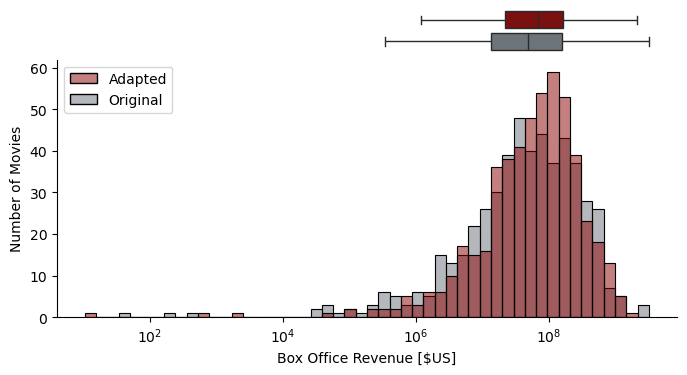

In [39]:
plot_revenue_histogram(df=trial_1_balanced_df)

From the histogram we can see a slight difference between adapted and original movies. 
- Check if this is a significant difference at the 5% significance level
- Fit linear model to determine the average influence to the movie revenue

In [40]:
test_result = ttest_ind(trial_1_balanced_df.query('movie_is_adaptation').movie_revenue_log,
          trial_1_balanced_df.query('~movie_is_adaptation').movie_revenue_log)
print(f'The p-value of the t-test is {test_result.pvalue:.4f}')

model = smf.ols('movie_revenue_log ~ movie_is_adaptation', data=trial_1_balanced_df)
results = model.fit()
intercept = results.params[0]
slope = results.params[1]
book_adaptation_impact_million = (10**(intercept + slope) - 10**intercept)/1e6
print(f'Impact of Adaptation [in million $US]: {book_adaptation_impact_million:.2f}')

The p-value of the t-test is 0.0192
Impact of Adaptation [in million $US]: 12.93


We have obtained a significant result (at the 5% level) with a p-value of approximately 2%. On average, movies based on books generate about 13 million dollars more in revenue than those which are not book adaptations. 


### Are Movie Adaptations more successful? 
While this might be of great interest to Hollywood executives (albeit very few might be reading this), as movie enthusiasts, our main concern often lies with the quality of these films. It's a common perception that movie adaptations disappoint fans of the original books. But is this really true? Do book adaptations generally result in lower-quality movies? To explore this, we'll analyze ratings from IMDb. We will employ methods like exact matching and propensity score analysis to address potential biases in our assessment.

In [42]:
# select only entries with imdb rating not null 
trial_2_df = (adaptation_df
                .query('imdb_rating.notnull()')
                .reset_index(drop=True)
             )

X_df = trial_2_df[relevant_cols]
y_df = trial_2_df['movie_is_adaptation']


# logisitic regression to compute propensity scores
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])
pipe.fit(X_df, y_df)
trial_2_df['propensity_score'] = pipe.predict_proba(X_df)[:,1]


# match treatment and control groups
treatment_df = trial_2_df.query('movie_is_adaptation').reset_index(drop=False)
control_df = trial_2_df.query('~movie_is_adaptation').reset_index(drop=False)

matching_df = (treatment_df
               .merge(
                   control_df, 
                   on=['movie_release'] + genre_cols[:15] + country_cols[:5], 
                   suffixes=['_treatment', '_control']
                   )
               .assign(
                     similarity = lambda x: x.apply(lambda y: get_similarity(y.propensity_score_treatment, y.propensity_score_control), axis=1)
               )
               .query('similarity > 0.975')
            )

G = nx.Graph()
for _, row in tqdm(matching_df.iterrows(), total=len(matching_df), desc='Building Graph'):
    similarity = row.similarity
    index_control = row['index_control']
    index_treatment = row['index_treatment']
    G.add_weighted_edges_from([(index_control, index_treatment, similarity)])

print('Computing Maximum Weight Matching...')
matching = nx.max_weight_matching(G)
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
trial_2_balanced_df = trial_2_df.iloc[matched]

Building Graph: 100%|██████████| 14258/14258 [00:01<00:00, 8004.06it/s]


Computing Maximum Weight Matching...


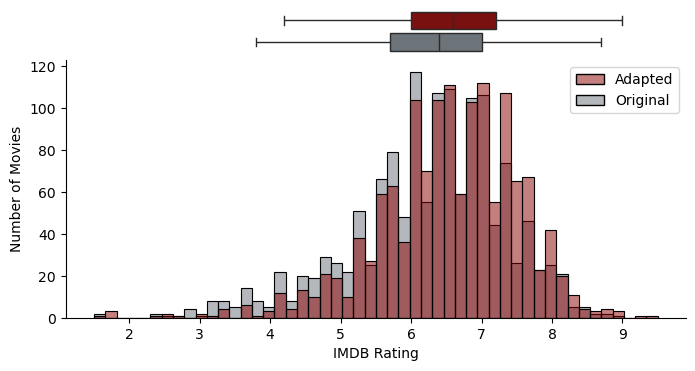

In [46]:
plot_imdb_histogram(df=trial_2_balanced_df)

In [50]:
test_result = ttest_ind(trial_2_balanced_df.query('movie_is_adaptation').imdb_rating,
                        trial_2_balanced_df.query('~movie_is_adaptation').imdb_rating)
print(f'The p-value of the t-test is {test_result.pvalue:.14f}')

model = smf.ols('imdb_rating ~ movie_is_adaptation', data=trial_2_balanced_df)
results = model.fit()
slope = results.params[1]
print(f'Book Adaptation Impact on Rating: {slope:.2f}')

The p-value of the t-test is 0.00000000000132
Book Adaptation Impact on Rating: 0.28


## Which Books are turned into Movies?
Now let us compare the books that were turned into movies against the general distribution of book. For this let us combine the books form the `adaptation_df` with the books from the `book_df`. To conduct our analyses we will only consider books for which we have both the data from Wikimedia as well as the Goodreads rating. 

In [120]:
book_cols = [col for col in adaptation_df.columns if col.startswith('book_')]

adapted_book_df = (adaptation_df
                   .query('movie_is_adaptation == 1 & book_rating.notna()')
                   .assign(book_adapted = 1)
                   .loc[:, book_cols + ['book_adapted']]
                   .reset_index(drop=True)
                )

# make sure that we do not consider books that have an adaptation in the book_df
adapted_wikidata_ids = adapted_book_df['book_wikidata_id'].unique()

book_df = (book_df
           .query('book_wikidata_id not in @adapted_wikidata_ids')
           .assign(book_adapted = 0)
           .loc[:, book_cols + ['book_adapted']]
           .reset_index(drop=True)
          )

# as we only consider movies between 1950 and 2010, we will only consider books that were published until 2010
adapted_book_df = (
                   pd.concat([book_df, adapted_book_df], axis=0)
                   .reset_index(drop=True)
                   .assign(
                        label=lambda x: x.book_adapted.map({1: "Adapted", 0: "Not-Adapted"}).astype("category").cat.reorder_categories(["Not-Adapted", "Adapted"], ordered=True)
                   )
                   .query('book_release <= 2010')
                  )

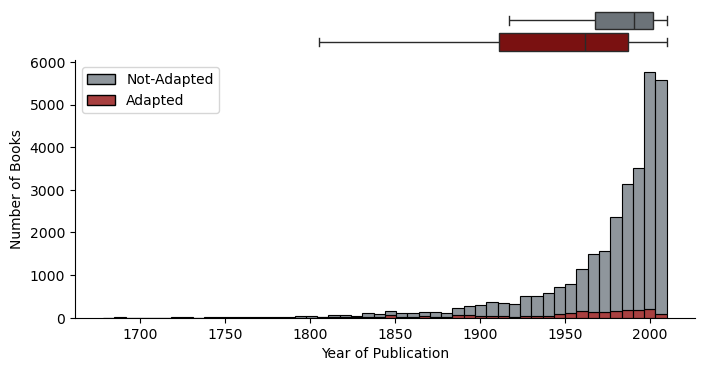

The p-value of the t-test is 0.00000000000000.
The average adapted books is 31.34 years older than the average non-adapted book.


In [141]:
make_book_histplot(df=adapted_book_df, col='book_release', x_label='Year of Publication')

test_result = ttest_ind(adapted_book_df.query('book_adapted == 1 & book_release.notna()').book_release,
                        adapted_book_df.query('book_adapted == 0 & book_release.notna()').book_release)
print(f'The p-value of the t-test is {test_result.pvalue:.14f}.')
diff_means = adapted_book_df.query('book_adapted == 1').book_release.mean() - adapted_book_df.query('book_adapted == 0').book_release.mean()
print(f'The average adapted books is {-diff_means:.2f} years older than the average non-adapted book.')

From the plot it is clear to see that the books that are adapted are generally speaking older. One possible explenation for this could be that Hollywood executives tend to adapt classics that already stood the test of time.

Another reason is that it takes time until a book is adapted. Even if a producer would start with the work on the adaptation at the day of the book publication (which is very unlikely) it would take him a couple of years to adapt it. So many of the books published from 2000 until 2010 are yet to get their adaptation. 

So let us redo this but this time only consider books from before 1990 that were around for long enough to get their adaptation. 

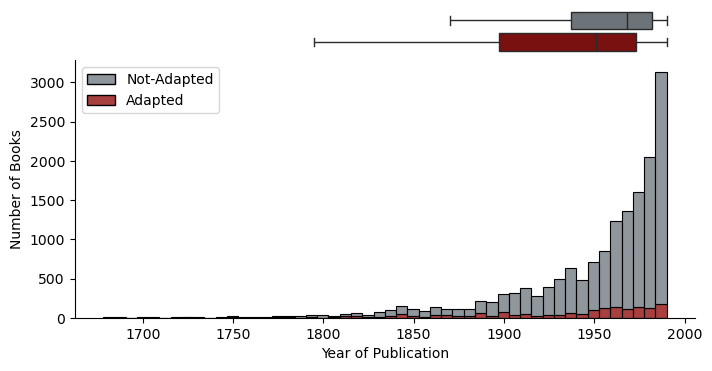

The p-value of the t-test is 0.00000000000000.
The average adapted books is 21.16 years older than the average non-adapted book.


In [142]:
adapted_book_before_1990_df = adapted_book_df.query('book_release <= 1990')

make_book_histplot(df=adapted_book_before_1990_df, col='book_release', x_label='Year of Publication')

test_result = ttest_ind(adapted_book_before_1990_df.query('book_adapted == 1 & book_release.notna()').book_release,
                        adapted_book_before_1990_df.query('book_adapted == 0 & book_release.notna()').book_release)
print(f'The p-value of the t-test is {test_result.pvalue:.14f}.')
diff_means = adapted_book_before_1990_df.query('book_adapted == 1').book_release.mean() - adapted_book_before_1990_df.query('book_adapted == 0').book_release.mean()
print(f'The average adapted books is {-diff_means:.2f} years older than the average non-adapted book.')

While less drastic there still seems to be a significant difference between adapted and non-adapted books in terms of publication year. 

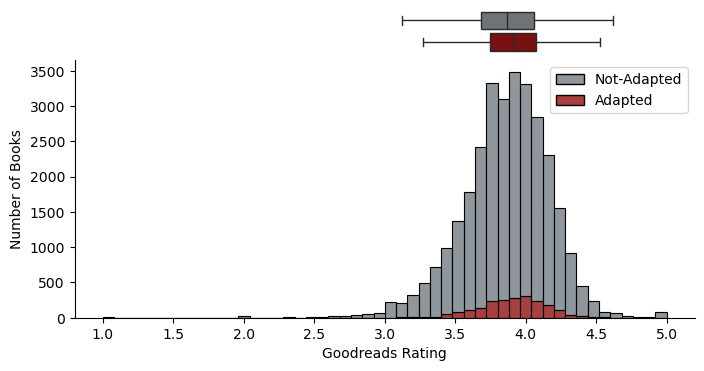

The p-value of the t-test is 0.00000007125894.
The mean rating of adapted book is 0.04 higher than that of not-adapted books.


In [139]:
make_book_histplot(df=adapted_book_df, col='book_rating', x_label='Goodreads Rating')

test_result = ttest_ind(adapted_book_df.query('book_adapted == 1 & book_rating.notna()').book_rating,
                        adapted_book_df.query('book_adapted == 0 & book_rating.notna()').book_rating)
print(f'The p-value of the t-test is {test_result.pvalue:.14f}.')
diff_means = adapted_book_df.query('book_adapted == 1').book_rating.mean() - adapted_book_df.query('book_adapted == 0').book_rating.mean()
print(f'The mean rating of adapted book is {diff_means:.2f} higher than that of not-adapted books.')

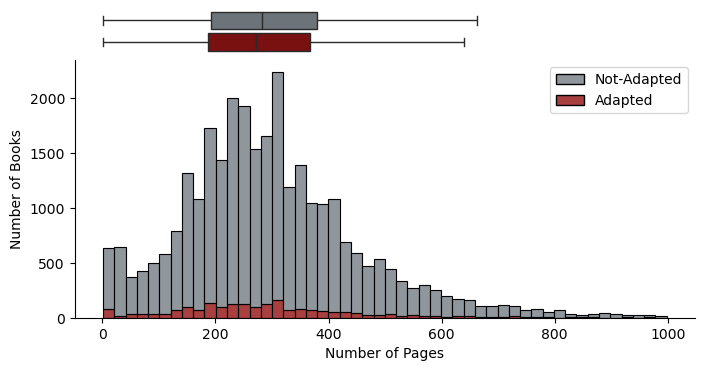

The p-value of the t-test is 0.04663060797125.
The average adapted book has 8.73 less pages than the average not-adapted book.


In [219]:
make_book_histplot(df=adapted_book_df.query('book_pages <= 1000'), col='book_pages', x_label='Number of Pages')

test_result = ttest_ind(adapted_book_df.query('book_adapted == 1 & book_pages.notna()').book_pages,
                        adapted_book_df.query('book_adapted == 0 & book_pages.notna()').book_pages)
print(f'The p-value of the t-test is {test_result.pvalue:.14f}.')
diff_means = adapted_book_df.query('book_adapted == 1').book_pages.mean() - adapted_book_df.query('book_adapted == 0').book_pages.mean()
print(f'The average adapted book has {-diff_means:.2f} less pages than the average not-adapted book.')

While the difference in Goodreads rating seems to quite significant, the actual difference between the mean ratings is not large.

/usr/local/anaconda3/envs/ada/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


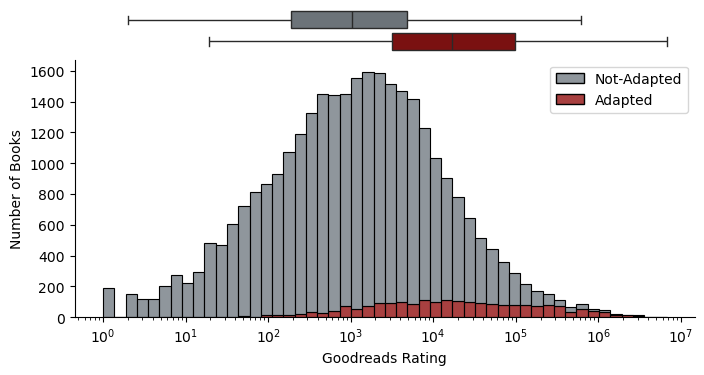

The p-value of the t-test is 0.00000000000000.
The average adapted book has 143725.85 more ratings than the average not-adapted book.


In [150]:
make_book_histplot(df=adapted_book_df, col='book_ratings_count', x_label='Goodreads Rating', log=True)

test_result = ttest_ind(adapted_book_df.query('book_adapted == 1 & book_ratings_count.notna()').book_ratings_count,
                        adapted_book_df.query('book_adapted == 0 & book_ratings_count.notna()').book_ratings_count)
print(f'The p-value of the t-test is {test_result.pvalue:.14f}.')
diff_means = adapted_book_df.query('book_adapted == 1').book_ratings_count.mean() - adapted_book_df.query('book_adapted == 0').book_ratings_count.mean()
print(f'The average adapted book has {diff_means:.2f} more ratings than the average not-adapted book.')

It seems like the number of ratings sets apart the adapted movies from the non-adapted ones. In a way the number of ratings could serve as a proxy for how pupular a certain book is. The more people read it, the more will leave a rating for it. And for sure, when thinking about the next book to adapt, popular books seem convenient as they are already established brands with their own fanbase. 

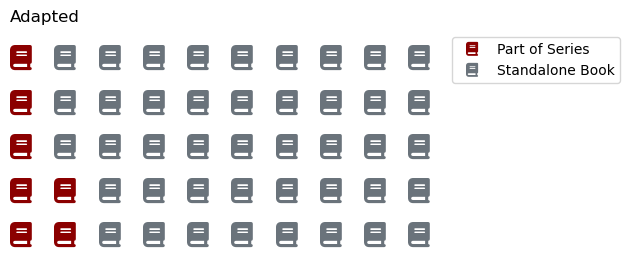

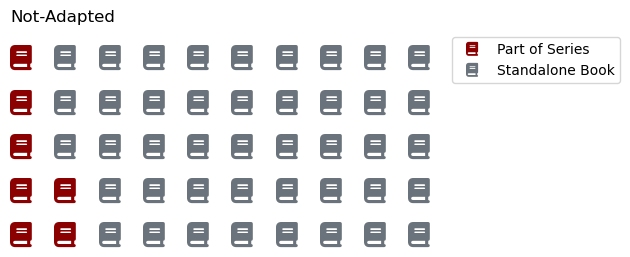

In [154]:
adapted_book_adapted_df = adapted_book_df.query('book_adapted == 1')
adapted_book_not_adapted_df = adapted_book_df.query('book_adapted == 0')

fraction_part_of_series = round(adapted_book_adapted_df.book_part_of_series.mean() * 100) / 2
fraction_not_part_of_series = (50 - fraction_part_of_series)
data_adapted = {'Part of Series': fraction_part_of_series, 'Standalone Book': fraction_not_part_of_series}

fraction_part_of_series = round(adapted_book_not_adapted_df.book_part_of_series.mean() * 100) / 2
fraction_not_part_of_series = (50 - fraction_part_of_series)
data_not_adapted = {'Part of Series': fraction_part_of_series, 'Standalone Book': fraction_not_part_of_series}

fig_1 = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=data_adapted,
    colors=['#8B0000', '#6a737b'],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons=['book', 'book'],
    font_size=18,
    icon_legend=True,
    title={'label': 'Adapted', 'loc': 'left'}
)

fig_2 = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=data_adapted,
    colors=['#8B0000', '#6a737b'],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons=['book', 'book'],
    font_size=18,
    icon_legend=True,
    title={'label': 'Not-Adapted', 'loc': 'left'}
)


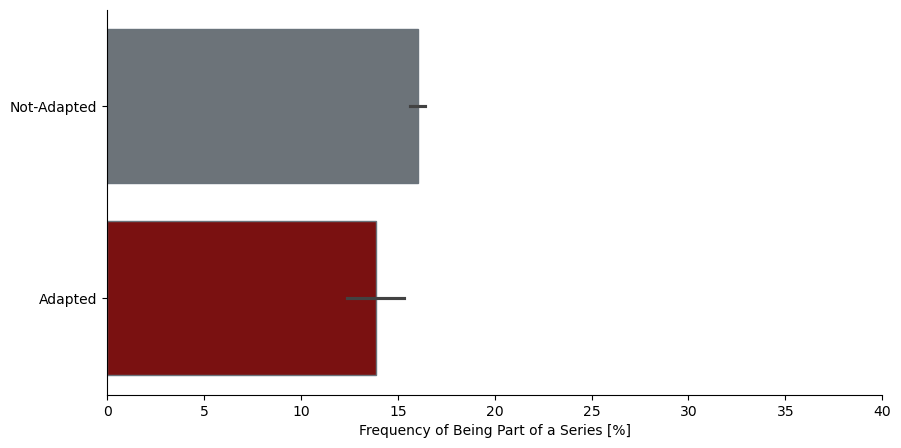

In [168]:
adapted_book_df['book_part_of_series_pct'] = adapted_book_df['book_part_of_series'] * 100

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=adapted_book_df, y='label', x='book_part_of_series_pct', palette=['#6a737b', '#8B0000'], edgecolor='#6a737b', ax=ax)
plt.xlabel('Frequency of Being Part of a Series [%]')
plt.ylabel('')
plt.xlim(0,40)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

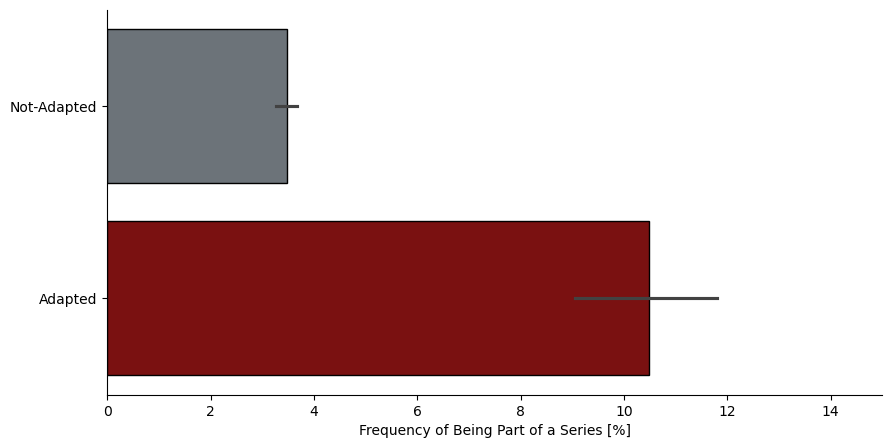

In [181]:
adapted_book_df['book_won_price_pct'] = adapted_book_df['book_won_price'] * 100

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=adapted_book_df, y='label', x='book_won_price_pct', palette=['#6a737b', '#8B0000'], edgecolor='.0', ax=ax)
plt.xlabel('Frequency of Being Part of a Series [%]')
plt.ylabel('')
plt.xlim(0,15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

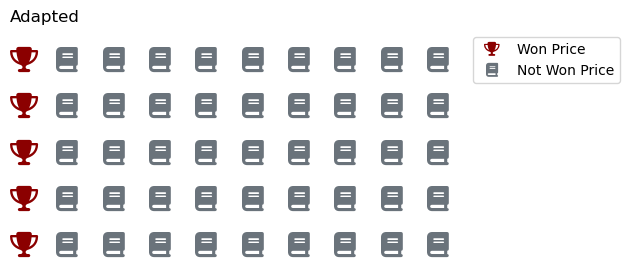

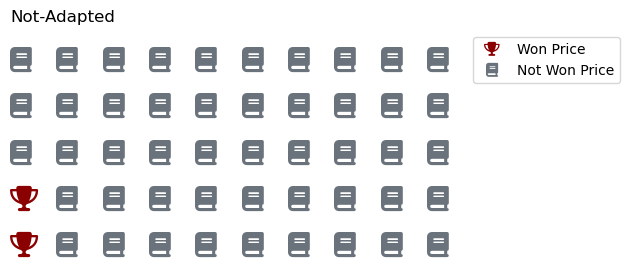

In [177]:
adapted_book_adapted_df = adapted_book_df.query('book_adapted == 1')
adapted_book_not_adapted_df = adapted_book_df.query('book_adapted == 0')

fraction_won_price = round(adapted_book_adapted_df.book_won_price.mean() * 100) / 2
fraction_not_won_price = (50 - fraction_won_price)
data_adapted = {'Won Price': fraction_won_price, 'Not Won Price': fraction_not_won_price}

fraction_won_price = round(adapted_book_not_adapted_df.book_won_price.mean() * 100) / 2
fraction_not_won_price = (50 - fraction_won_price)
data_not_adapted = {'Won Price': fraction_won_price, 'Not Won Price': fraction_not_won_price}

fig_1 = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=data_adapted,
    colors=['#8B0000', '#6a737b'],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons=['trophy', 'book'],
    font_size=18,
    icon_legend=True,
    title={'label': 'Adapted', 'loc': 'left'}
)

fig_2 = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=data_not_adapted,
    colors=['#8B0000', '#6a737b'],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons=['trophy', 'book'],
    font_size=18,
    icon_legend=True,
    title={'label': 'Not-Adapted', 'loc': 'left'}
)


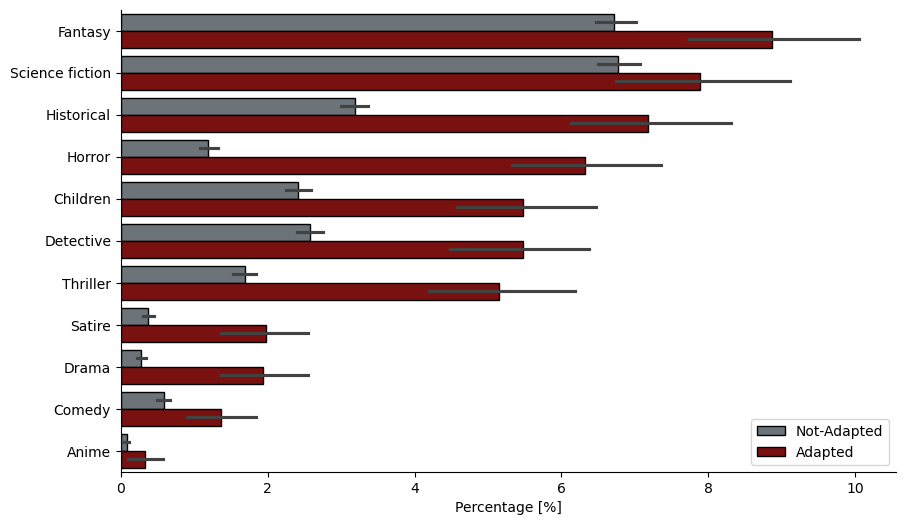

In [227]:
genre_cols = adapted_book_df.columns[9:20].tolist()
book_genre_df = (adapted_book_df
                 .loc[:, genre_cols + ['label']].copy(deep=True)
                 .melt(id_vars='label', var_name='genre', value_name='value')
                 .assign(
                     genre=lambda x: x.genre.str.replace('science_fiction', 'Science Fiction').str.split('_').str[-1].str.capitalize(),
                     value= lambda x: x.value * 100
                 )
                )

order = (book_genre_df
         .query('label == "Adapted"')
         .groupby(['genre'])
         .agg({'value': 'mean'})
         .reset_index()
         .sort_values('value', ascending=False)
         ['genre']
        )

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=book_genre_df, y='genre', x='value', hue='label', palette=['#6a737b', '#8B0000'], edgecolor='.0', ax=ax, order=order)
plt.xlabel('Percentage [%]')
plt.ylabel('')
ax.get_legend().set_title("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

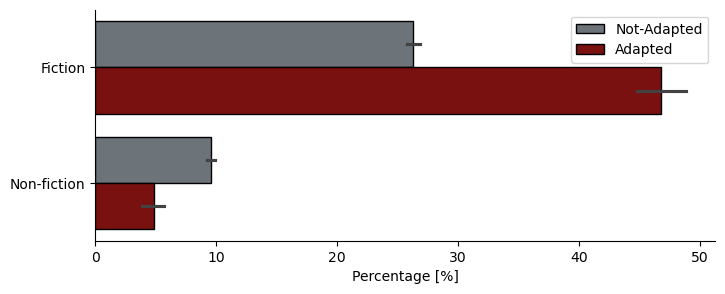

In [220]:
fiction_cols = adapted_book_df.columns[7:9].tolist()
book_genre_df = (adapted_book_df
                 .loc[:, fiction_cols + ['label']].copy(deep=True)
                 .melt(id_vars='label', var_name='genre', value_name='value')
                 .assign(
                     genre=lambda x: x.genre.str.replace('non_fiction', 'Non-Fiction').str.split('_').str[-1].str.capitalize(),
                     value= lambda x: x.value * 100
                 )
                )

order = (book_genre_df
         .query('label == "Adapted"')
         .groupby(['genre'])
         .agg({'value': 'mean'})
         .reset_index()
         .sort_values('value', ascending=False)
         ['genre']
        )

fig, ax = plt.subplots(figsize=(8, 3))
sns.barplot(data=book_genre_df, y='genre', x='value', hue='label', palette=['#6a737b', '#8B0000'], edgecolor='.0', ax=ax, order=order)
plt.xlabel('Percentage [%]')
plt.ylabel('')
ax.get_legend().set_title("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

## Pedict which Books will be adapted
As we have seen in our analysis books that were adapted distinguish themselfes regarding several predictors. So it should be possible to train a classifier that can predict which books will be adapted in the future. 

In [232]:
X_cols = fiction_cols + genre_cols + ['book_release', 'book_part_of_series', 'book_won_price', 'book_rating', 'book_ratings_count', 'book_pages']
X = adapted_book_df.loc[:, X_cols].to_numpy()
y = adapted_book_df.loc[:, 'book_adapted'].to_numpy()

pipe = (Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier()),
    ])
)

sos = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ros = RandomOverSampler(random_state=42)

accuracies = []
pred_df_list = []

for train_index, test_index in tqdm(sos.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # oversample adapted books and fit model
    X_train, y_train = ros.fit_resample(X_train, y_train)
    pipe.fit(X_train, y_train)

    accuracies.append(pipe.score(X_test, y_test))
    pred_df_list.append(pd.DataFrame(X_test, columns=X_cols)
                        .assign(
                            proba = pipe.predict_proba(X_test)[:, 1],
                            y = y_test
                        )
                        .merge(adapted_book_df.iloc[test_index,:], 
                               on=X_cols, 
                               how='inner')
                        )

print(f'Mean Accuracy: {np.mean(accuracies):.2f} +- {np.std(accuracies):.3f}')
candidates_df = (pd.concat(pred_df_list, axis=0)
                 .drop_duplicates(subset=['book_wikidata_id'])
                 .query('y == 0 & proba > 0.5')
                )

0it [00:00, ?it/s]

5it [00:25,  5.04s/it]

Mean Accuracy: 0.95 +- 0.003


In [233]:
print("We found a total of {} books that are likely to be adapted.".format(len(candidates_df)))

We found a total of 352 books that are likely to be adapted.


In [353]:
candidates_df.sort_values('proba', ascending=False).head(10).loc[:, ['book_title', 'book_author', 'proba']]

,book_title,book_author,proba
116,Delta of Venus,Anaïs Nin,1.00
22,Chilly Scenes of Winter,Ann Beattie,1.00
1616,His Last Bow,Arthur Conan Doyle,1.00
378,Ten Little Niggers,Agatha Christie,0.91
2859,To the Lighthouse,Virginia Woolf,0.90
3776,Sophie's World,Jostein Gaarder,0.89
1667,White Noise,Don DeLillo,0.89
5720,Coming Up for Air,George Orwell,0.88
107,Black Beauty: retold in words of one syllable,Anna Sewell,0.88
4342,She's Come Undone,Wally Lamb,0.86


Interestingly except for 'She Come Undone' all of our top ten predictions have a movie adaptation. 

## Which Books make successful Adaptations?
Perfect, now we have around 350 potential candidate books that would make good adaptions. But which of them should we produce. Well let us analyze which book adaptations end up being successful at the box office. 

In [239]:
# we only will consider books that have a movie adaptation for which revenue data is available
adaptation_revenue_df = adaptation_df.query('movie_is_adaptation == 1 & movie_revenue.notnull()')

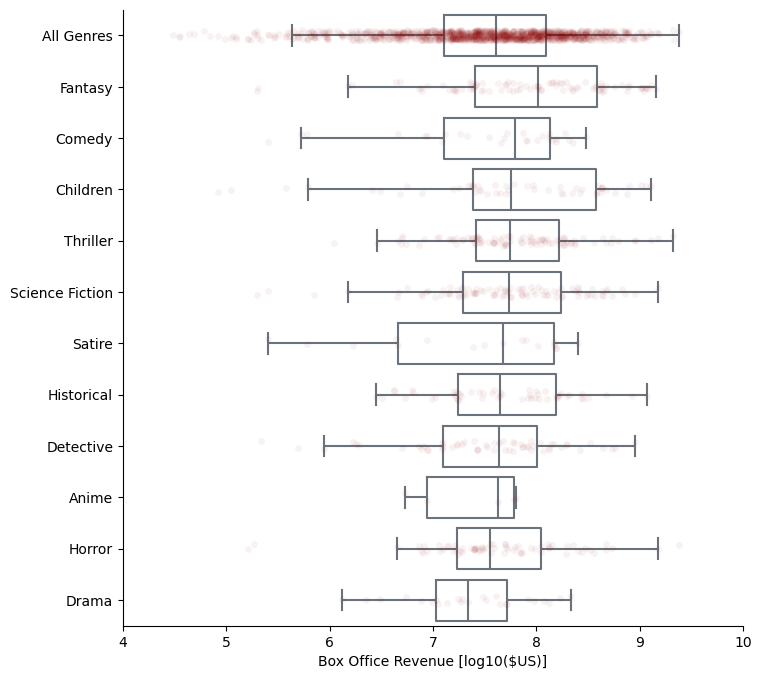

In [278]:
genre_list = []
genre_list.append(adaptation_revenue_df
                  .assign(genre = "All Genres")
                  .loc[:, ['genre', 'movie_revenue_log']]
                 )

for col in genre_cols:
    genre_list.append(adaptation_revenue_df
                      .query(f'{col} == 1')
                      .assign(genre = " ".join(col.split('_')[1:]).replace('_', ' ').title())
                      .loc[:, ['genre', 'movie_revenue_log']]
            )
genre_df = pd.concat(genre_list, axis=0)
genre_order = (genre_df
         .query('genre != "All Genres"')
         .groupby('genre')
         .agg({'movie_revenue_log': 'median'})
         .sort_values('movie_revenue_log', ascending=False)
         .index
         .tolist()
        )
genre_order = ['All Genres'] + genre_order

fig = plt.figure(figsize=(8, 8))
ax = sns.boxplot(
    data=genre_df, x="movie_revenue_log", y="genre", color='#6a737b', 
    fill=False, flierprops={"marker": None}, order=order
)
sns.stripplot(
    data=genre_df, x="movie_revenue_log", y="genre", alpha=.05, color='#8B0000', ax=ax, 
    order=order
)

ax.set_xlabel('Box Office Revenue [log10($US)]')
# set x lim 
ax.set_xlim(4, 10)
ax.set_ylabel('')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

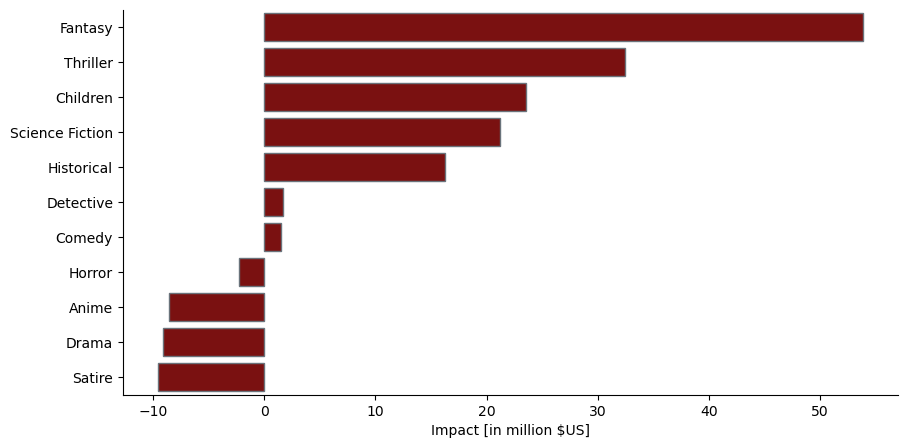

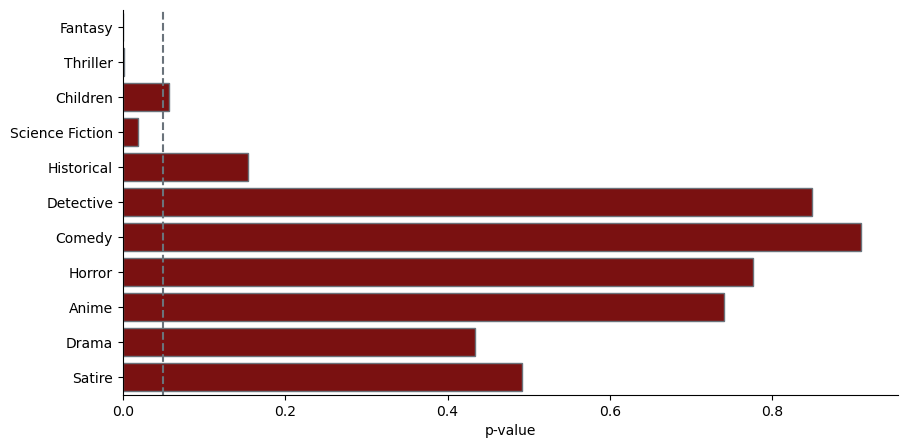

In [276]:
results = []
for col in genre_cols:
    t_test_result = ttest_ind(adaptation_revenue_df.query(f'{col} == 1').movie_revenue_log,
                              adaptation_revenue_df.query(f'{col} == 0').movie_revenue_log)
    model = smf.ols('movie_revenue_log ~ ' + col, data=adaptation_revenue_df)
    result = model.fit()
    intercept = result.params[0]
    slope = result.params[1]
    impact = (10**(intercept + slope) - 10**intercept)/1e6
    results.append({"genre": " ".join(col.split('_')[1:]).replace('_', ' ').title(), "t_test_p_value": t_test_result.pvalue, "impact": impact})
results_df = pd.DataFrame(results)

impact_order = results_df.sort_values('impact', ascending=False).genre.tolist()
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=results_df, y='genre', x='impact', color='#8B0000', edgecolor='#6a737b', ax=ax, order=impact_order)
plt.xlabel('Impact [in million $US]')
plt.ylabel('')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# plot pvalues 
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=results_df, y='genre', x='t_test_p_value', color='#8B0000', edgecolor='#6a737b', ax=ax, order=impact_order)
plt.xlabel('p-value')
plt.ylabel('')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.axvline(x=0.05, color='#6a737b', linestyle='--')

When I think of successful book adaptations I have to think about famous book series like Lord of the Rings or Harry Potter. Following this intuition, let us see if adaptations of book series perform better at the box office. 

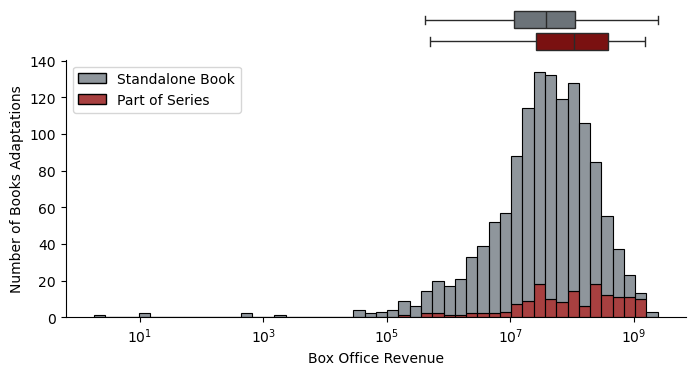

In [286]:
make_book_revenue_histplot(df=adaptation_revenue_df, col="book_part_of_series", labels=['Part of Series', 'Standalone Book'])

In [291]:
test_result = ttest_ind(adaptation_revenue_df.query('book_part_of_series == 1').movie_revenue_log,
          adaptation_revenue_df.query('book_part_of_series == 0').movie_revenue_log)
print(f'The p-value of the t-test is {test_result.pvalue:.14f}')

model = smf.ols('movie_revenue_log ~ book_part_of_series', data=adaptation_revenue_df)
results = model.fit()
intercept = results.params[0]
slope = results.params[1]
book_adaptation_impact_million = (10**(intercept + slope) - 10**intercept)/1e6
print(f'Impact of being part of series [in million $US]: {book_adaptation_impact_million:.2f}')

The p-value of the t-test is 0.00000000043534
Impact of being part of series [in million $US]: 58.15


## ToDo: matching with propensity scores ... 

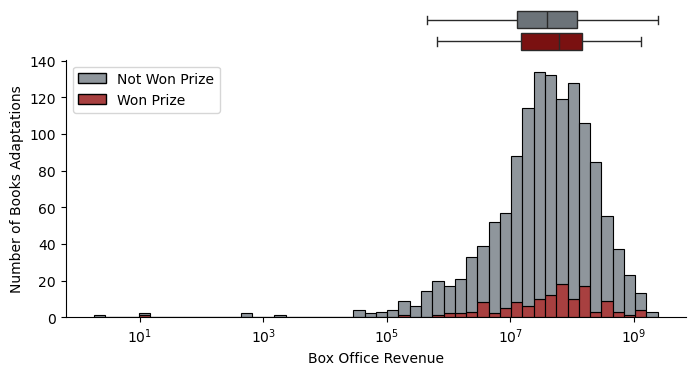

In [290]:
make_book_revenue_histplot(df=adaptation_revenue_df, col="book_won_price", labels=['Won Prize', 'Not Won Prize'])

In [292]:
test_result = ttest_ind(adaptation_revenue_df.query('book_won_price == 1').movie_revenue_log,
          adaptation_revenue_df.query('book_won_price == 0').movie_revenue_log)
print(f'The p-value of the t-test is {test_result.pvalue:.14f}')

model = smf.ols('movie_revenue_log ~ book_won_price', data=adaptation_revenue_df)
results = model.fit()
intercept = results.params[0]
slope = results.params[1]
book_adaptation_impact_million = (10**(intercept + slope) - 10**intercept)/1e6
print(f'Impact of having won a prize [in million $US]: {book_adaptation_impact_million:.2f}')

The p-value of the t-test is 0.25189395364494
Impact of having won a prize [in million $US]: 7.88


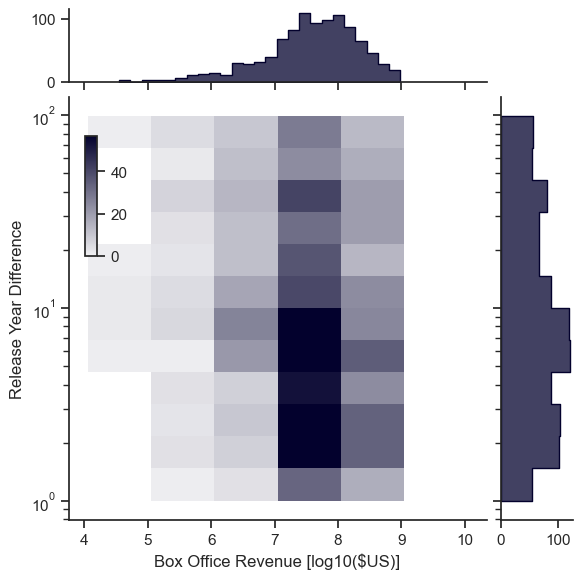

Pearson Correlation: -0.15, p-value: 0.00000047984258


In [314]:
adaptation_revenue_df['release_diff'] = adaptation_revenue_df.movie_release - adaptation_revenue_df.book_release

sns.set_theme(style="ticks")
g = sns.JointGrid(data=adaptation_revenue_df.query("release_diff < 100 & release_diff > 0 & movie_revenue_log > 4 & movie_revenue_log < 9"), x="movie_revenue_log", y="release_diff", marginal_ticks=True)
g.ax_joint.set(yscale="log")
cax = g.figure.add_axes([.15, .55, .02, .2])
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")
g.set_axis_labels("Box Office Revenue [log10($US)]", "Release Year Difference")
plt.show()

pearson = pearsonr(adaptation_revenue_df.query('release_diff.notna() & release_diff > 0').movie_revenue_log, 
                    adaptation_revenue_df.query('release_diff.notna() & release_diff > 0').assign(release_diff = lambda x: np.log(x.release_diff)).release_diff)
print(f'Pearson Correlation: {pearson[0]:.2f}, p-value: {pearson[1]:.14f}')

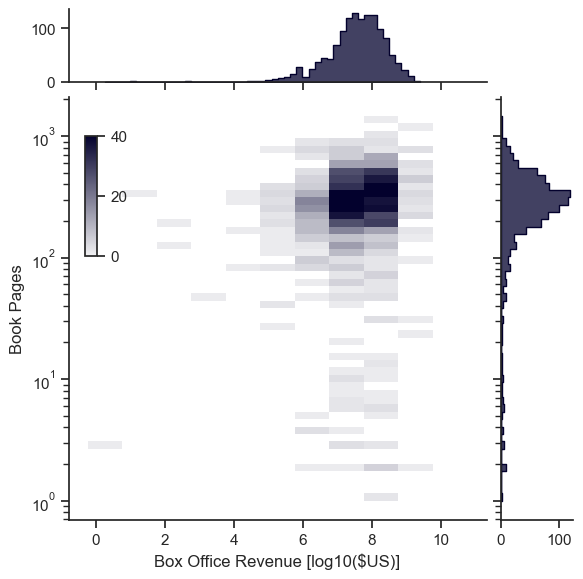

Pearson Correlation: 0.10, p-value: 0.00221714497145


In [313]:
sns.set_theme(style="ticks")
g = sns.JointGrid(data=adaptation_revenue_df, x="movie_revenue_log", y="book_pages", marginal_ticks=True)
g.ax_joint.set(yscale="log")
cax = g.figure.add_axes([.15, .55, .02, .2])
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")
g.set_axis_labels("Box Office Revenue [log10($US)]", "Book Pages")
plt.show()

pearson =  pearsonr(adaptation_revenue_df.query('book_pages.notna() & book_pages > 0').movie_revenue_log,
                    adaptation_revenue_df.query('book_pages.notna() & book_pages > 0').assign(book_pages = lambda x: np.log(x.book_pages)).book_pages)
print(f'Pearson Correlation: {pearson[0]:.2f}, p-value: {pearson[1]:.14f}')

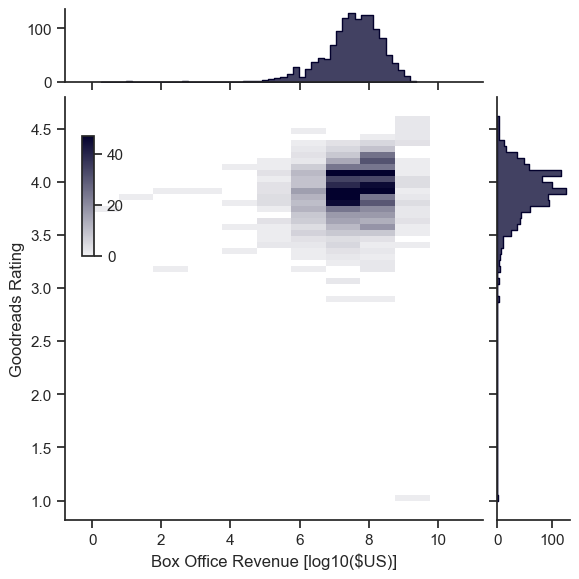

Pearson Correlation: 0.15, p-value: 0.00000097679622


In [317]:
sns.set_theme(style="ticks")
g = sns.JointGrid(data=adaptation_revenue_df, x="movie_revenue_log", y="book_rating", marginal_ticks=True)
cax = g.figure.add_axes([.15, .55, .02, .2])
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")
g.set_axis_labels("Box Office Revenue [log10($US)]", "Goodreads Rating")
plt.show()

pearson =  pearsonr(adaptation_revenue_df.query('book_rating.notna()').movie_revenue_log,
                    adaptation_revenue_df.query('book_rating.notna()').book_rating)
print(f'Pearson Correlation: {pearson[0]:.2f}, p-value: {pearson[1]:.14f}')

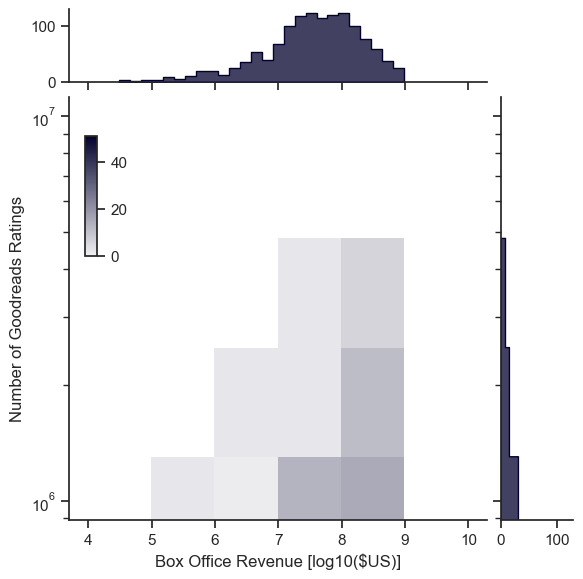

Pearson Correlation: 0.24, p-value: 0.00000000000001


In [322]:
sns.set_theme(style="ticks")
g = sns.JointGrid(data=adaptation_revenue_df.query("movie_revenue_log > 4 & movie_revenue_log < 9"), x="movie_revenue_log", y="book_ratings_count", marginal_ticks=True)
g.ax_joint.set(yscale="log")
cax = g.figure.add_axes([.15, .55, .02, .2])
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)

g.plot_marginals(sns.histplot, element="step", color="#03012d")
g.set_axis_labels("Box Office Revenue [log10($US)]", "Number of Goodreads Ratings")
plt.show()

pearson =  pearsonr(adaptation_revenue_df.query('book_ratings_count.notna() & book_ratings_count > 0').movie_revenue_log,
                    adaptation_revenue_df.query('book_ratings_count.notna() & book_ratings_count > 0').assign(book_ratings_count = lambda x: np.log(x.book_ratings_count)).book_ratings_count)
print(f'Pearson Correlation: {pearson[0]:.2f}, p-value: {pearson[1]:.14f}')

So we found a few predictors for the success of a book adaptation. Using them we will fit a simple Linear Regression model on the data and use it to predict the suceess for all candidates for adaptation. 

In [348]:
reg_cols = genre_cols + ['book_release', 'book_part_of_series', 'book_won_price', 'book_rating', 'book_ratings_count', 'book_pages', 'release_diff']
adaptation_df['movie_revenue_log'] = np.log10(adaptation_df.movie_revenue)
X = adaptation_revenue_df.loc[:, reg_cols].to_numpy()
y = adaptation_revenue_df.loc[:, 'movie_revenue_log'].to_numpy()

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

scores = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Mean MSE: {-np.mean(scores):.2f} +- {np.std(scores):.3f}')

Mean MSE: 0.73 +- 0.149


In [349]:
# refit the model on the whole dataset
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])
pipe.fit(X, y)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('reg', LinearRegression())])

In [351]:
candidates_df = candidates_df.assign(release_diff = lambda x: (2010 - x.book_release))
X_candidates = candidates_df.loc[:, reg_cols].to_numpy()
candidates_df['pred_log_revenue'] = pipe.predict(X_candidates)
(candidates_df
    .sort_values(by='pred_log_revenue', ascending=False)
    .loc[:, ['book_title', 'book_author', 'pred_log_revenue']]
    .head(20)
)

,book_title,book_author,pred_log_revenue
1147,A Game of Thrones,George R. R. Martin,8.918123
2891,Harry Potter and the Prisoner of Azkaban,J. K. Rowling,8.649172
3665,City of Bones,Cassandra Clare,8.574923
1874,A Clash of Kings,George R. R. Martin,8.539215
2927,"The Lion, the Witch, and the Wardrobe",C. S. Lewis,8.277563
4429,The Hobbit,J. R. R. Tolkien,8.134647
1166,The Alchemist,Paulo Coelho,8.105493
3193,The Shadow of the Wind,Carlos Ruiz Zafón,8.092038
5603,Equal Rites,Terry Pratchett,8.047903
5654,Killing Floor,Lee Child,8.023519


Let us digest this list a one by one:

- While Game of Thrones did not became the next big movie adaptation it turned it found its way to the sceen as arguably one of the most successful tv-series ever
- Harry Potter and the Prisoner of Azkaban already is a movie (arguably the best of the whole Harry Potter series). It seems like it was missing in our dataset. 
- City of Bones actually was turned into a movie in 2013. However it was a big flop with a revenue of only 95 million dollars
- We also found the Narnia series in here. Some of the movies were made before 2010 and were missing in our dataset. However the series was a big commercial success with a revenue of over a billion worldwide. 
- The Hobbit actually got not only one but a series of 3 movies starting 2012, which performed very well at the box office.
- Just recently in 2023 Legendary Entertainment aquired the film rights for the alchemist so let's see what the future holds for this adaptation
- While the shadow of the wind certainly would make a good movie, the author said that he refused some proposals by some film studios
- Equal Rites did not get an adaptation yet (Hollywood executives, this is your chance). 
- Similar to Game of Thrones Killing Floor was adapted in the 2022 TV series Reacher
- Red Storm rising so far was not turned into a movie, but an excellent board game
- The Farthest Shore and the  farthest Shore were not turned into movies yet
- Holes got it's adaptation in 2003 earning 71 million dollars worldwide
- Water for Elefants was turned a critically acclaimed movie in 2011
- Interstingly for Neverwhere it was the other way aroud that is the book was adapted form a tv series